In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
class BernoulliBanditEnv(object): 
    # Clase que define el environment donde el reward es 0 o 1 dependiendo de una probabilidad p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)     # define set of actions

        if len(p)==1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # La mejor accion dado el enviroenmentenenas

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])


In [205]:
class Agent(object):
    # Clase que define al agente. Cada agente cuenta con una regla de decisión y una regla de aprendizaje.
    
    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule

        if decision_rule == "epsilon-greedy":
            self.epsilon = param["epsilon"]
        
        if decision_rule == "UCB":
            self.UCB_param = param["UCB_param"]
        
        if decision_rule == "gradient":
            self.lr = param["lr"]
    
    def environment(self, env, init_q):
        # inicializa el environment
        self.env = env                                  
        self.k = env.num_arms                           
        self.actions = np.arange(self.k)                
        self.act_count = np.zeros(self.k)               
        self.iteration = 0     
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha = np.random.uniform(size=self.k)
            self.beta  = np.random.uniform(size=self.k)
        if len(init_q) == self.k:
            self.q_estimate = init_q
        else:
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))
        # for gradient bandits, initial preference table
        self.pref = np.empty(self.k)
        self.pref.fill(1.0/self.k)
        self.last_reward = 0
        
    def learn(self, a, r):
        # Guardo last_reward para el gradient bandits
        self.last_reward = r
        # dada una acción y una recompenza, actualiza la value function.
        if self.learning_rule == "averaging":
            self.q_estimate[a] += 1/self.act_count[a] * (r - self.q_estimate[a])
            
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha[a] += r
            self.beta[a]  += 1 - r 
            
    def act(self):
        # realiza una acción.
        self.iteration += 1 
        
        if self.decision_rule == "greedy":
            pol_actions = np.argwhere(self.q_estimate == np.amax(self.q_estimate)).ravel()
            pol_action  = np.random.choice(pol_actions)
            selected_action = pol_action
            pass
        if self.decision_rule == "epsilon-greedy":
            eps = self.epsilon
            if np.random.choice([True, False], p=[1-eps, eps]):
                # Policy action
                # argmax of ALL max estimates
                #pol_actions = self.q_estimate[self.q_estimate == np.amax(self.q_estimate)]
#                 pol_actions = np.argwhere(self.q_estimate == np.amax(self.q_estimate)).ravel()
#                 # If several "best" actions, choose one randomly
#                 pol_action  = np.random.choice(pol_actions)
                pol_action = randomArgmax(self.q_estimate)
                selected_action = pol_action
            else:
                # Random action
                selected_action = np.random.choice([0,1])
            pass
        if self.decision_rule == "UCB":
            # TODO: cambiar el argmax por algo que tome en cuenta todos los maxs
            # TODO: Definir nueva func allArgMaxs
            c = self.UCB_param
            # if N(a)==0 > a is a maximizing action
            uncertainty = np.sqrt(np.log(self.iteration)/np.maximum(1,self.act_count))
            # no quiero que las acciones no elegidas me pisen acciones con
            # pesos equivalentes.
            # Con maximizing action considero su valor a partir del maximo de las
            # acciones ya elegidas.
            part_candidates = self.q_estimate + c*np.where(self.act_count>0, uncertainty, 0)
            candidates = np.where(self.act_count>0, part_candidates, np.amax(part_candidates))
            selected_action = randomArgmax(candidates)
        # for gradient bandits:
        # pref: sera un vector de probabilidades (preferencias)
        #       con 1 valor para cada accion posible
        if self.decision_rule == "gradient":
            # Completar con lo visto en clase
            # Tomar H como mi funcion de preferencia que actualiza cuando compara
            # el reward R que obtuve con mi reward promedio estimad R'
            # Debo actualizar dos cosas:
            #    la preferencia de la accion que tome (aumenta o disminuye)
            #    la preferencia de las otras acciones (disminuyen o aumentan)
            for a in self.actions:
                pi = softmax_vect(self.pref)
                # softmax: pi = e**pref(a)/sum(e**pref(all-a))
                # pi = softmax(pref(a), pref)
                # TODO: Preguntar: 
                #       1. uso q_estimate como promedio de rewards, no se si es lo correcto
                #       2. esta bien considerar la funcion de preferencia una probabilidad? o puede tomar valores negativos?
                if self.iteration == 1:
                    r_diff = 0
                else:
                    r_diff = self.last_reward - self.q_estimate[self.last_action]
                    if a == self.last_action:
                        self.pref[a] += self.lr * r_diff * (1-pi[a])
                    else:
                        self.pref[a] -= self.lr * r_diff * pi[a]
                    # making sure we dont get negatives 
            self.pref = np.maximum(0, self.pref)         
            # making sure pref is prob distribution function (sums to one)
            self.pref = self.pref / np.sum(self.pref)
            selected_action = np.random.choice(self.actions, p=self.pref)
            #print(self.iteration, self.pref, selected_action)
            self.last_action = selected_action
            pass
        if self.decision_rule == "Thompson":
            # COMPLETAR
            pass
        self.act_count[selected_action] += 1
        return selected_action

In [194]:
np.arange(4)

array([0, 1, 2, 3])

In [169]:
def randomArgmax(v):
    # returns a maximizing value's argument
    arguments = np.argwhere(v == np.amax(v)).ravel()
    # If several "best" actions, choose one randomly
    arg = np.random.choice(arguments)
    return arg

In [170]:
def softmax_vect(v):
    """Returns a vector with all softmax values"""
    exp_vect = np.exp(v)
    return exp_vect/np.sum(exp_vect)

## Gradient Bandits

Gradient bandits actualiza la preferencia de cada accion deacuerdo a 
la diferencia entre el reward obtenido y el promedio

<img src="img/gradient-bandits.png" width="500" align="left" />

In [171]:
def simulateBandits(agents, narms, initp=None, initq=None, repetitions=1000, N=100):
    # función que realiza las simulaciones de los agentes. Se define el número de repeticiones que seran
    #  promediadas y el número de pasos N. agents es una lista de agentes.
    
    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(initq == None) else np.zeros(narms))
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

In [209]:
def plot_results(agents, actions, rewards):
    # repeticiones a promediar
    reps = 100
    # numero de pasos 
    N = 2000
    # Generating data
    data = np.asarray(simulateBandits(agents, narms=narms, initp=initp, initq=None, repetitions=reps, N=N))
    time_steps = np.arange(1, len(data[0])+1)
    plt.plot(time_steps, data[0,:], 'r.-', label=None, linewidth=0.2)
    plt.show()

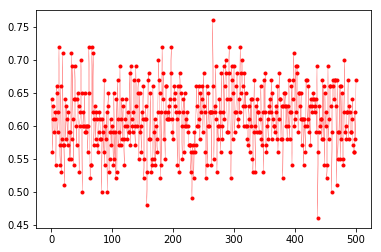

In [173]:
params = {"epsilon": 0.05, "UCB_param": 1.4, "lr": 0.1}
agent = Agent("averaging", "gradient", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initq)

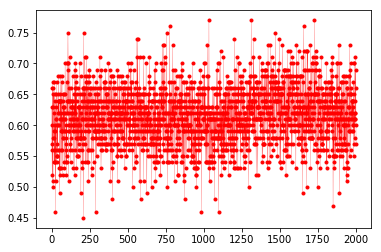

In [208]:
# new agent
params = {"epsilon": 0.05, "UCB_param": 1.4, "lr": 0.1}
agent = Agent("averaging", "gradient", params)
agents = [agent]
# plot simulation with n arms
initp = [0.4, 0.8] #prob of each arm of giving reward
narms = len(initp)
data = np.asarray(simulateBandits(agents, narms=narms, initp=initp, initq=None, repetitions=100, N=2000))
#print(data)
time_steps = np.arange(1, len(data[0])+1)
# reward 
plt.plot(time_steps, data[0,:], 'r.-', label=None, linewidth=0.2)
plt.show()

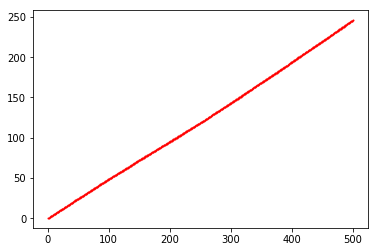

In [175]:
# cumulative reward
plt.plot(time_steps, np.cumsum(data[1,:]), 'r.', label=None, markersize=2, linewidth=0.5)
plt.show()

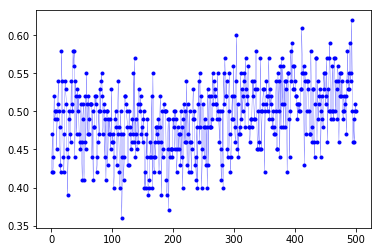

In [207]:
# agent rate of choosing best arm
plt.plot(time_steps, data[1,:], 'b.-', label=None, linewidth=0.2)
plt.show()

In [177]:
for reward, arm in zip(data[0], data[1]):
    print(arm, " - ", reward)

0.42  -  0.61
0.47  -  0.53
0.42  -  0.58
0.44  -  0.54
0.52  -  0.56
0.49  -  0.66
0.5  -  0.65
0.5  -  0.68
0.45  -  0.58
0.49  -  0.64
0.51  -  0.6
0.54  -  0.61
0.5  -  0.67
0.48  -  0.63
0.43  -  0.53
0.42  -  0.53
0.58  -  0.61
0.54  -  0.61
0.5  -  0.65
0.44  -  0.56
0.42  -  0.61
0.47  -  0.67
0.54  -  0.72
0.53  -  0.6
0.51  -  0.64
0.45  -  0.58
0.39  -  0.49
0.44  -  0.56
0.49  -  0.59
0.5  -  0.63
0.47  -  0.62
0.46  -  0.58
0.54  -  0.62
0.51  -  0.59
0.5  -  0.6
0.58  -  0.59
0.56  -  0.61
0.58  -  0.62
0.44  -  0.49
0.54  -  0.6
0.52  -  0.58
0.47  -  0.58
0.53  -  0.6
0.5  -  0.6
0.52  -  0.61
0.47  -  0.59
0.46  -  0.52
0.45  -  0.53
0.51  -  0.6
0.46  -  0.59
0.41  -  0.58
0.49  -  0.58
0.51  -  0.58
0.41  -  0.53
0.46  -  0.52
0.52  -  0.59
0.45  -  0.56
0.55  -  0.63
0.51  -  0.74
0.47  -  0.64
0.52  -  0.61
0.47  -  0.55
0.49  -  0.71
0.51  -  0.59
0.51  -  0.64
0.51  -  0.57
0.44  -  0.54
0.5  -  0.62
0.41  -  0.56
0.48  -  0.63
0.48  -  0.54
0.52  -  0.66
0.51  -

In [178]:
import sys
print(sys.version)

3.7.0 (default, Jun 28 2018, 13:15:42) 
[GCC 7.2.0]


In [179]:
np.argmax([2,2])

0

# Ejercicios:

1) Completar pertinentemente el código donde diga "COMPLETAR".

2) Realizar simulaciones con un bandit de 2 brazos (P = [0.4, 0.8]) para cada una de las reglas de decisión y graficar la recompensa promedio, la recompensa acumulada y el porcentaje de veces que fue elegido el mejor brazo en función de los pasos. Interprete los resultados.

3) Realizar simulaciones con un bandit de 10 brazos (P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) para cada una de las reglas de decisión y graficar la recompensa promedio, la recompensa acumulada y el porcentaje de veces que fue elegido el mejor brazo en función de los pasos. Interprete los resultados.

4) Estudie la dependencia del hiperparametro epsilon en la regla de decisión epsilon-greedy.


### Bandits de 2 brazos

#### Greedy

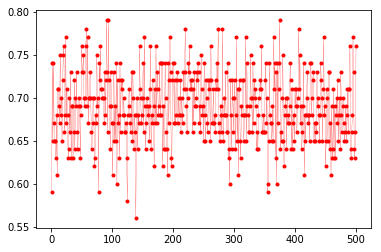

In [180]:
agent = Agent("averaging", "greedy")
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initq)

#### Epsilon-Greedy

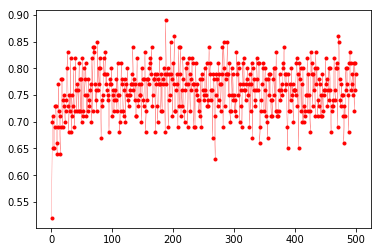

In [181]:
params = {"epsilon": 0.2}
agent = Agent("averaging", "epsilon-greedy", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initq)

#### UCB

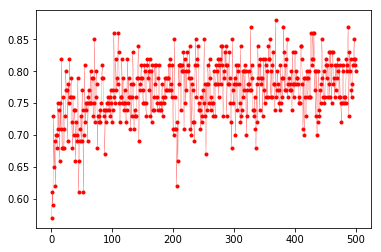

In [188]:
params = {"UCB_param": 1.4}
agent = Agent("averaging", "UCB", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initq)

#### Gradient

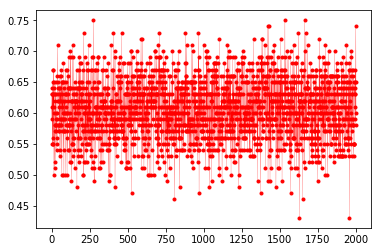

In [211]:
params = {"lr": 0.01}
agent = Agent("averaging", "gradient", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initq)